## Fitting an ARIMA model to the Disney stock.

Authors: Ben Wilke, Nathan Wall and Laura Ludwig

Date: 7/2/2019

In [1]:
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline

First we use the pandas data reader to read in the adjusted closing prices from the disney stock over the last 4 years.

In [2]:
from pandas_datareader import data as web

pd.core.common.is_list_like = pd.api.types.is_list_like

start = datetime.datetime(2015, 6, 1)
end = datetime.datetime(2019, 6, 1)

price = web.DataReader('DIS', 'yahoo', start, end)
price.index = pd.to_datetime(price.index)

In [3]:
price.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-06-01,111.769997,110.550003,111.480003,110.959999,6778900.0,104.680077
2015-06-02,111.250000,110.019997,110.919998,110.750000,4425900.0,104.481964
2015-06-03,111.820000,110.500000,110.750000,111.169998,4510300.0,104.878197
2015-06-04,111.250000,109.989998,110.949997,110.300003,5748200.0,104.057434
2015-06-05,110.769997,109.800003,110.300003,110.300003,4323500.0,104.057434


In [4]:
price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2015-06-01 to 2019-05-31
Data columns (total 6 columns):
High         1008 non-null float64
Low          1008 non-null float64
Open         1008 non-null float64
Close        1008 non-null float64
Volume       1008 non-null float64
Adj Close    1008 non-null float64
dtypes: float64(6)
memory usage: 55.1 KB


The reported prices of the stock does not account for prices on weekends and holidays. In order to account for missing information we will use the forward fill method to assign a value for these days.

In [5]:
# Since time series forecasting assumes fixed time periods, fill the value over the weekend/holiday days that are missing
price1 = price.resample('1D').ffill()
price1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2015-06-01 to 2019-05-31
Freq: D
Data columns (total 6 columns):
High         1461 non-null float64
Low          1461 non-null float64
Open         1461 non-null float64
Close        1461 non-null float64
Volume       1461 non-null float64
Adj Close    1461 non-null float64
dtypes: float64(6)
memory usage: 79.9 KB


Now that we have a repeated value for everyday over the last 4 years lets start looking at our data and testing some assumption.

/home/newall/anaconda3/envs/timeSeries/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, "Disney's Closing Price (6/1/2015 - 6/1/2019)")

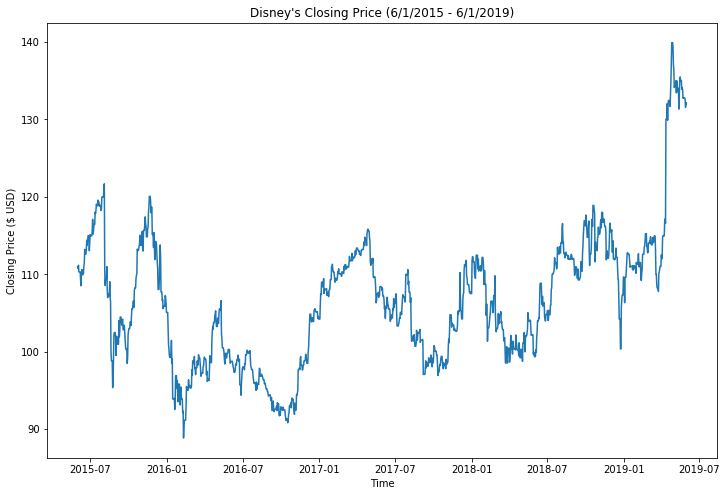

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(price1['Close'])
plt.xlabel('Time')
plt.ylabel('Closing Price ($ USD)')
plt.title("Disney's Closing Price (6/1/2015 - 6/1/2019)")

The above shows that the stock appears to have multiple up and down periods over the last year, but overall there does appear to be an overall trend or seasonality. Also the mean and variance over this period seems to be relatively stable. Although, we will use the Dickey-Fuller test to determine if our data is stationary.

In [7]:
ts = price1['Close']

In [8]:
ts.head(10)

Date
2015-06-01    110.959999
2015-06-02    110.750000
2015-06-03    111.169998
2015-06-04    110.300003
2015-06-05    110.300003
2015-06-06    110.300003
2015-06-07    110.300003
2015-06-08    109.290001
2015-06-09    108.519997
2015-06-10    110.000000
Freq: D, Name: Close, dtype: float64

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(60).mean()
    rolstd = timeseries.rolling(60).std()
    staticmean = timeseries.mean()
    
    fig, ax = plt.subplots(figsize=(12, 8))

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    static = plt.axhline(y=staticmean, color='black', linestyle='--', label = 'Static Mean')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

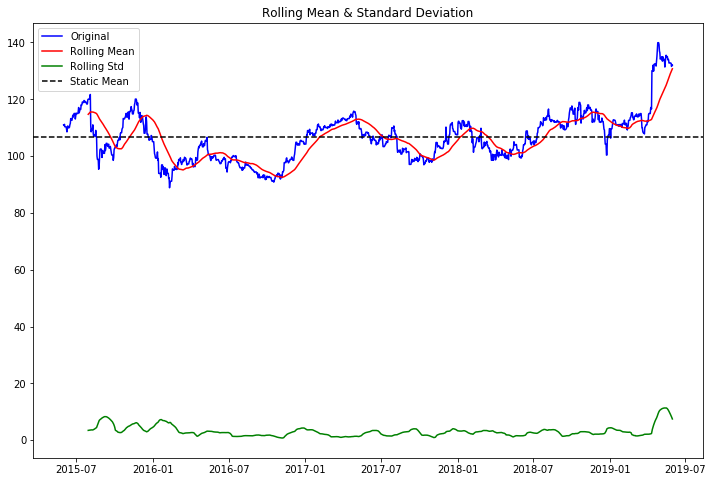

Results of Dickey-Fuller Test:
Test Statistic                   -1.784126
p-value                           0.388371
#Lags Used                        3.000000
Number of Observations Used    1457.000000
Critical Value (1%)              -3.434846
Critical Value (5%)              -2.863526
Critical Value (10%)             -2.567827
dtype: float64


In [90]:
test_stationarity(ts)

The results of this test fail to reject (p-val = 0.388) meaning we cannot assume that this series in stationary. In order to make our model stationary we apply a transformation. 

In [12]:
stock_mean = ts.mean()
print('Mean stock price over time period is: ' , stock_mean)

Mean stock price over time period is:  106.56813817477895


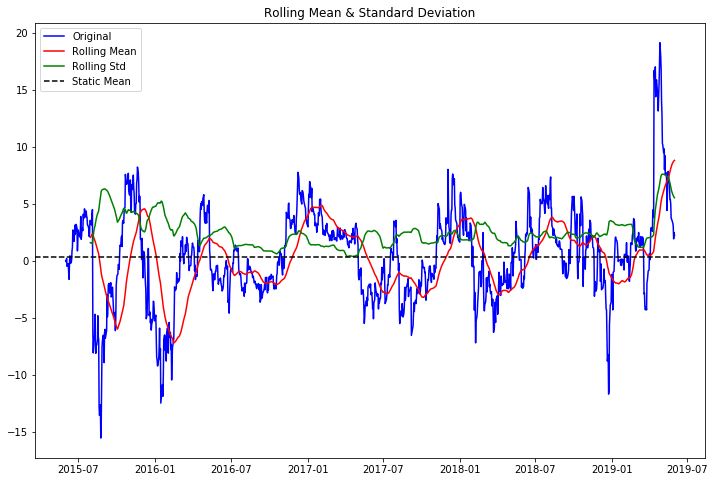

Results of Dickey-Fuller Test:
Test Statistic                   -4.551336
p-value                           0.000159
#Lags Used                        7.000000
Number of Observations Used    1453.000000
Critical Value (1%)              -3.434859
Critical Value (5%)              -2.863531
Critical Value (10%)             -2.567830
dtype: float64


In [10]:
# If the null hypothesis in the Dickey-Fuller test can't be rejected, we need to do some kind of transformation to make the ts stationary.
# This block is testing exponential weighted moving average
expwighted_avg = ts.ewm(span=60).mean()
ts_ewma_diff = ts - expwighted_avg
test_stationarity(ts_ewma_diff)

The resulting transformation shows the series is now centered around zero, with many of those longer runs above and below the mean reduced. We also are able to the mean (shown in green) is mostly stable with some minor fluctuations at the beginning & end of the series. The standard deviation in red shows the similar pattern as the mean. This is a little concerning so we review the another method.

We will try using a difference method to address the stationary issue.

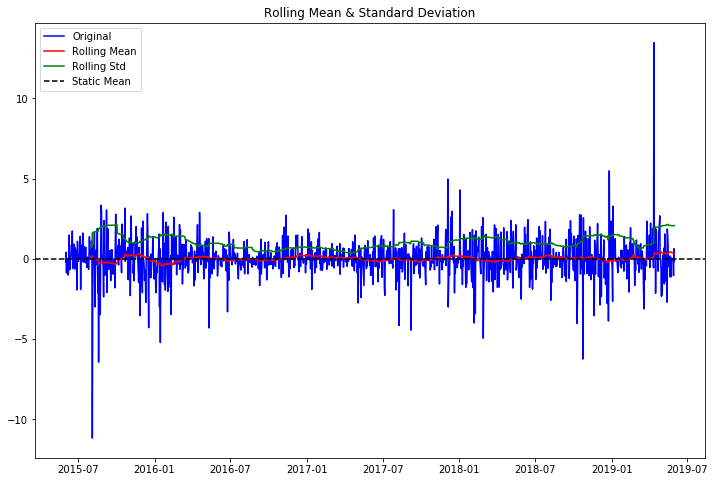

Results of Dickey-Fuller Test:
Test Statistic                -1.532124e+01
p-value                        4.061476e-28
#Lags Used                     6.000000e+00
Number of Observations Used    1.453000e+03
Critical Value (1%)           -3.434859e+00
Critical Value (5%)           -2.863531e+00
Critical Value (10%)          -2.567830e+00
dtype: float64


In [42]:
ts_diff = ts - ts.shift(1)
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

In [17]:
ts.head()

Date
2015-06-01    110.959999
2015-06-02    110.750000
2015-06-03    111.169998
2015-06-04    110.300003
2015-06-05    110.300003
Freq: D, Name: Close, dtype: float64

Both the EWMA & first order differencing appear to handle our stationary concerns so we will test with both for our ARIMA model.

In [12]:
from statsmodels.tsa.arima_model import ARIMA

##### First order differencing

In [55]:
# ARIMA - testing the ACF and PACF
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_diff, nlags=50)
lag_pacf = pacf(ts_diff, nlags=50, method='ols')

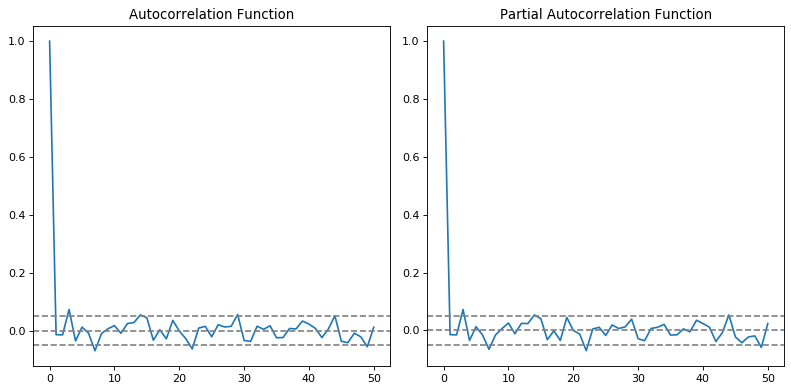

In [56]:
plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [57]:
model = ARIMA(ts_diff, order=(1, 1, 1), freq = 'D') 
results_ARIMA = model.fit(disp=-1)
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1459
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2236.631
Method:                       css-mle   S.D. of innovations              1.118
Date:                Sun, 30 Jun 2019   AIC                           4481.263
Time:                        11:22:08   BIC                           4502.405
Sample:                    06-03-2015   HQIC                          4489.150
                         - 05-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.419e-05   6.84e-05      1.231      0.219   -4.99e-05       0.000
ar.L1.D.Close    -0.0148      0.026     -0.564      0.573      -0.066       0.037
ma.L1.D.Close    -1.0000      0.002   -5

##### EWMA

In [58]:
# ARIMA - testing the ACF and PACF
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_ewma_diff, nlags=50)
lag_pacf = pacf(ts_ewma_diff, nlags=50, method='ols')

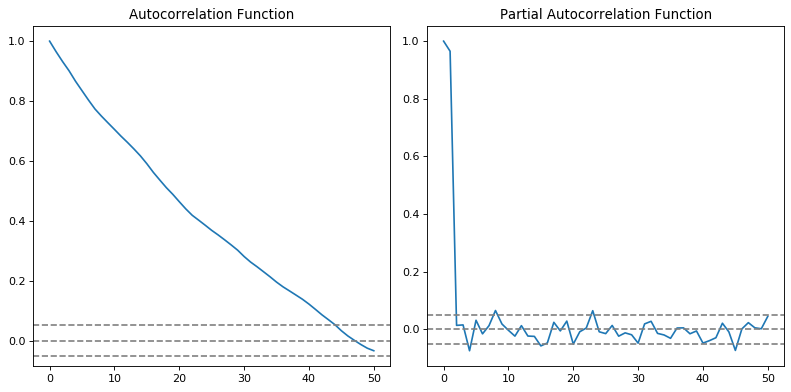

In [59]:
plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_ewma_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_ewma_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_ewma_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_ewma_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1461
Model:                     ARMA(1, 1)   Log Likelihood               -2186.885
Method:                       css-mle   S.D. of innovations              1.080
Date:                Sun, 30 Jun 2019   AIC                           4381.770
Time:                        11:25:41   BIC                           4402.917
Sample:                    06-01-2015   HQIC                          4389.658
                         - 05-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3938      0.789      0.499      0.618      -1.152       1.940
ar.L1.Close     0.9653      0.007    138.639      0.000       0.952       0.979
ma.L1.Close    -0.0144      0.027     -0.524    

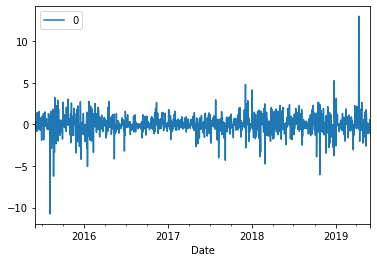

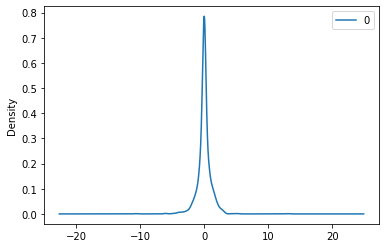

                 0
count  1461.000000
mean      0.000269
std       1.080450
min     -10.764356
25%      -0.294364
50%      -0.012450
75%       0.331450
max      13.004345


In [64]:
model = ARIMA(ts_ewma_diff, order=(1, 0, 1), freq = 'D') 
results_ARIMA = model.fit(disp=-1)
print(results_ARIMA.summary())
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Based on the above it seems like the EWMA fits a little better, so lets use that model.

Text(0.5, 1.0, 'RSS: 41.2839')

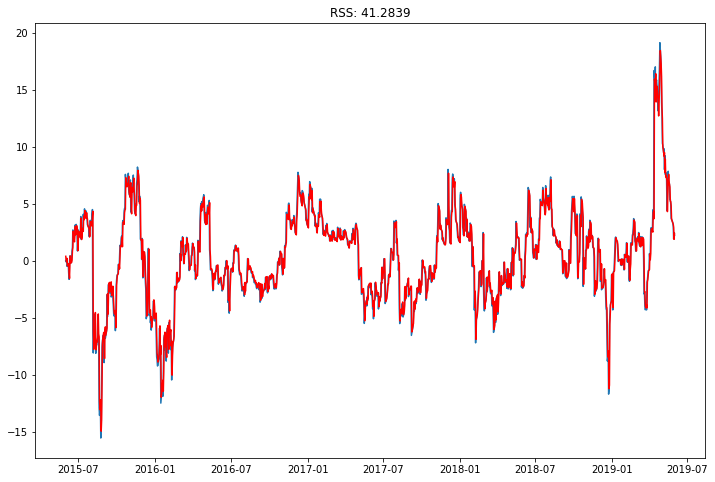

In [66]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(ts_ewma_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
x=pd.DataFrame(results_ARIMA.fittedvalues)
x=x.join(ts_ewma_diff)
x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
loss=np.sqrt(x['out'].sum())
plt.title('RSS: %.4f'% loss)

From visual inspection it seems to fit our current data well, but lets convert back to original scale.

Text(0.5, 1.0, 'RSS: 41.2839')

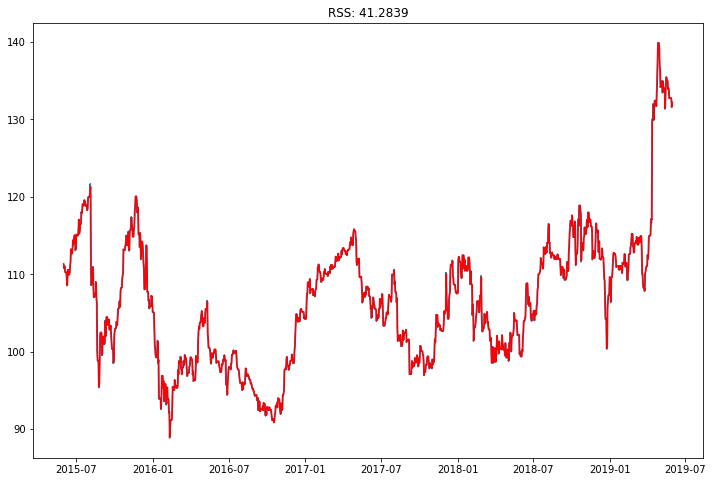

In [70]:
fit_ARIMA_ewma = pd.Series(results_ARIMA.fittedvalues, copy=True)
fit = results_ARIMA.fittedvalues + expwighted_avg

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(ts)
plt.plot(fit, color='red')
x=pd.DataFrame(fit)
x=x.join(ts)
x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
loss=np.sqrt(x['out'].sum())
plt.title('RSS: %.4f'% loss)

Lets fit an ARIMA model using just the prior values and predict on new values to see if would have predicted that 20 point jump in stock!

Below we fit a model using data from 6/1/2015 - 4/1/2019 and predict on the April-May closing values.

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1400
Model:                     ARMA(1, 1)   Log Likelihood               -2017.279
Method:                       css-mle   S.D. of innovations              1.021
Date:                Mon, 01 Jul 2019   AIC                           4042.558
Time:                        20:14:17   BIC                           4063.535
Sample:                    06-01-2015   HQIC                          4050.400
                         - 03-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0097      0.659     -0.015      0.988      -1.301       1.281
ar.L1.Close     0.9595      0.008    124.047      0.000       0.944       0.975
ma.L1.Close    -0.0071      0.029     -0.248    

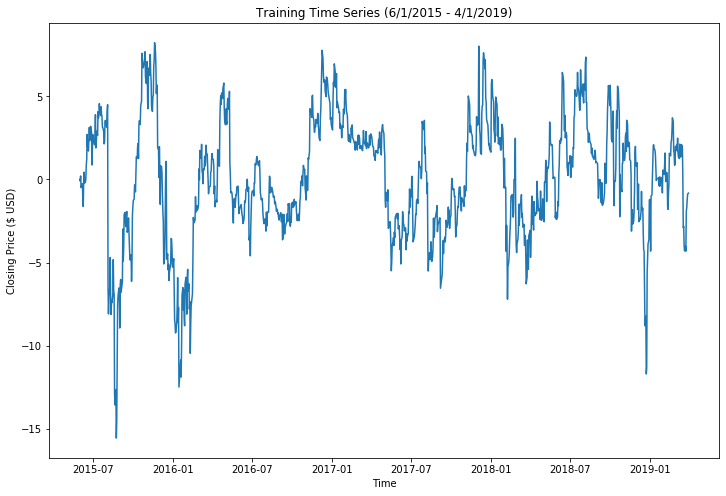

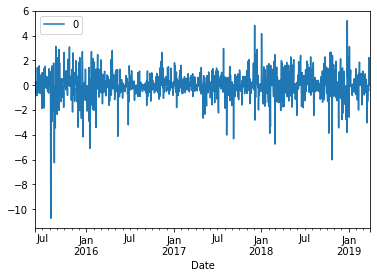

In [13]:
train = ts_ewma_diff[0:(len(ts_ewma_diff) - 61)]
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(train)
plt.xlabel('Time')
plt.ylabel('Closing Price ($ USD)')
plt.title("Training Time Series (6/1/2015 - 4/1/2019)")

test = ts_ewma_diff[(len(ts_ewma_diff) - 61):]

model = ARIMA(train, order=(1, 0, 1), freq = 'D') 
results_ARIMA = model.fit(disp=-1)
print(results_ARIMA.summary())
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot()
plt.show()

In [14]:
start_index = '2019-04-01'
end_index = '2019-05-31'
forecast = results_ARIMA.predict(start=start_index, end=end_index)

/home/newall/anaconda3/envs/timeSeries/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


Text(0.5, 1.0, 'RSS: 10.5541')

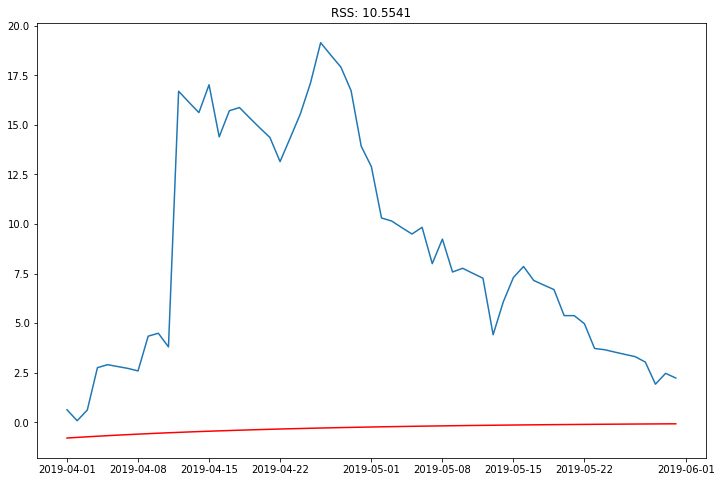

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(test)
plt.plot(forecast, color='red')
x=pd.DataFrame(forecast)
x=x.join(test)
x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
loss=np.sqrt((x['out'].sum()/len(x['out'])))
plt.title('RMSE: %.4f'% loss)